In [158]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt 
import seaborn as sns
# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.calibration import calibration_curve
from sklearn.base import BaseEstimator, TransformerMixin

# learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.2.3
numpy         Tested version: 1.21.5  Your version: 2.1.3
matplotlib    Tested version: 3.5.3   Your version: 3.8.4
scikit-learn  Tested version: 1.2.2   Your version: 1.6.1


In [159]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')
# drop sensitive features
# df = df.drop(columns=['age', 'ethnicity', 'gender'])
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [160]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.7  # maximum percentage of missing values for a column to be dropped

In [161]:
class DropHighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_drop = None

    def fit(self, X, y=None):
        # Calculate the correlation matrix
        X = pd.DataFrame(X)
        corr_matrix = X.corr()

        # Find pairs of features that are highly correlated
        highly_correlated = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if (corr_matrix.loc[i, j] > self.threshold) and (i != j)]

        # Remove one feature from each highly correlated pair
        self.features_to_drop = set()
        for i, j in highly_correlated:
            if i not in self.features_to_drop and j not in self.features_to_drop:
                self.features_to_drop.add(j)

        return self

    def transform(self, X):
        # Drop the highly correlated features
        X = pd.DataFrame(X)
        X_reduced = X.drop(columns=self.features_to_drop)
        return X_reduced

    def get_feature_names_out(self, input_features=None):
        new_features = []
        for i, feature in enumerate(input_features):
            if i not in self.features_to_drop:
                new_features.append(feature)
        return np.array(new_features)

In [162]:
binary_columns = [x for x in description_dict if description_dict[x]['Data Type'] == 'binary']

In [163]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem', # drop because of similarity with apache_3j_bodysystem
                    'ethnicity', 'age', 'gender' # Check if can be dropped
                    ],
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("drop_correlated", DropHighlyCorrelatedFeatures(threshold=0.8)),
                                  ("imputer", SimpleImputer(strategy="mean")),
                                  ("scaling", RobustScaler(quantile_range=(10, 90))),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")),
    ("constant", VarianceThreshold())
    ])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])

prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # display preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('drop_correlated',
                                                  DropHighlyCorrelatedFeatures()),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaling',
                                                  RobustScaler(quantile_range=(10,
                                                                               90)))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x361692710>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('constant',
                                                  VarianceThreshold())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x36178e500>)])

Time: 2.06s
Train set: 73370 rows, 108 columns
Validation set: 9171 rows, 108 columns
Test set: 9172 rows, 108 columns


## Evaluation

In [164]:
def plotCFMatrix(cm): # input is the confusion matrix from sklearn
    
    plt.figure(figsize=(8, 6))  
    sns.set_style("whitegrid") 
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [165]:
def Metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'TPR: {tpr}')
    print(f'TNR: {tnr}')
    return accuracy, precision, recall, f1, tpr, tnr

In [166]:
def calibration_plot(y_true, y_prob, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot of {model_name}')
    plt.legend()
    plt.show()

## XGBoost Model

In [167]:
%matplotlib inline

In [168]:
parameters = {
    'n_estimators': [50,100,200,500,1000],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'max_depth': [1,3,6,10],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0, 1.5],
}

In [169]:
# xg = xgb.XGBClassifier(random_state=42)
# g = RandomizedSearchCV(xg, parameters, cv=5, n_jobs=8)
# g.fit(X_train, y_train)
# cls_params = g.best_params_
# cls_params

In [170]:
y_train.value_counts()

hospital_death
0    67042
1     6328
Name: count, dtype: int64

In [171]:
from sklearn.utils import class_weight
from imblearn.over_sampling import ADASYN, RandomOverSampler
smote = RandomOverSampler(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

xg = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    n_estimators=100,
    max_depth=10,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_val)
xg_pred_proba = xg.predict_proba(X_val)[:, 1]

In [172]:
cm_xg = confusion_matrix(y_val, xg_pred)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_val, xg_pred)

Accuracy: 0.90
Precision: 0.44
Recall: 0.56
F1 Score: 0.49
TPR: 0.5590452261306532
TNR: 0.9327761194029851


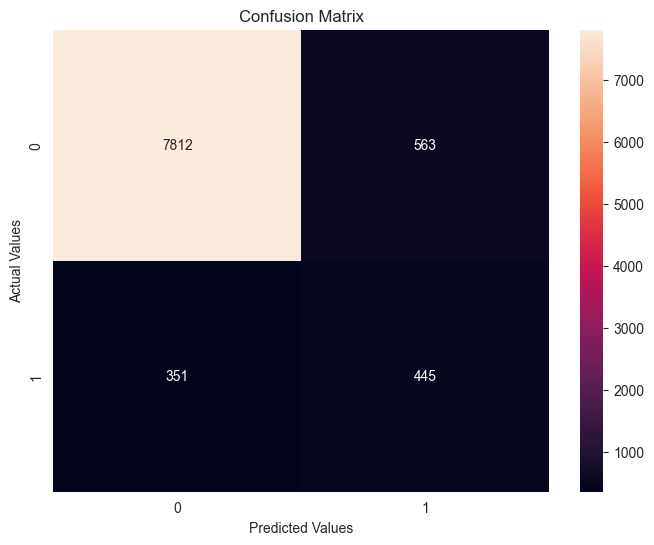

In [173]:
plotCFMatrix(cm_xg)

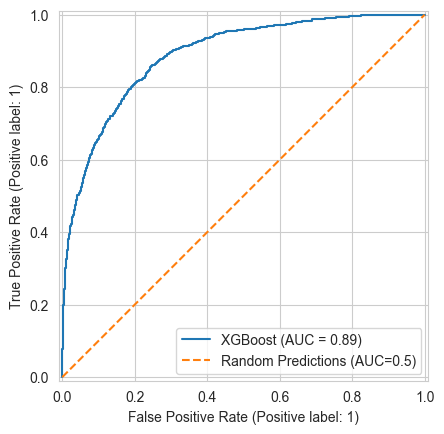

In [15]:
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=xg_pred_proba, name='XGBoost')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

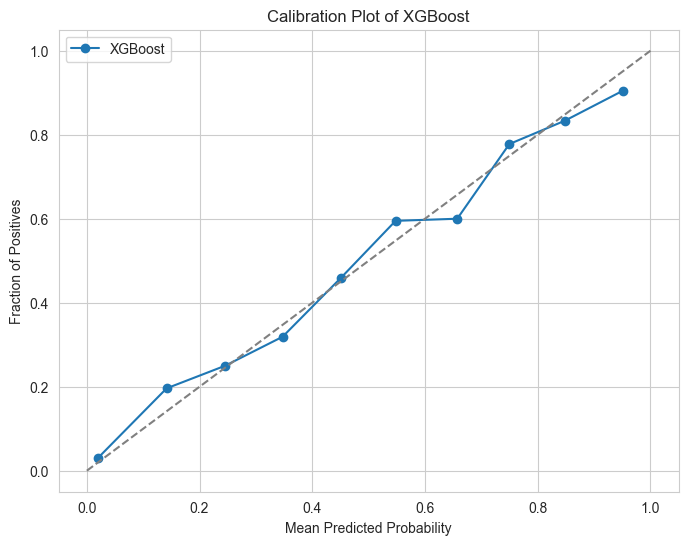

In [16]:
calibration_plot(y_val, xg_pred_proba, "XGBoost")

Top 10 most important features for XGBoost

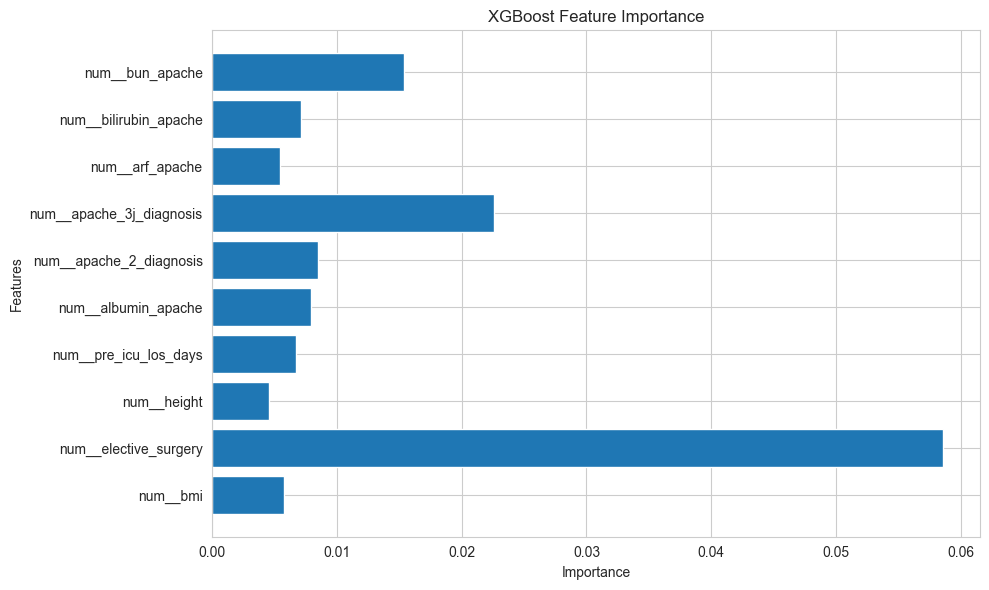

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(10), xg.feature_importances_[:10])
ax.set_yticks(range(10), X_train.columns[:10])
ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
fig.tight_layout()
fig.savefig("./feature_importance.pdf", format='pdf', dpi=600, bbox_inches='tight')

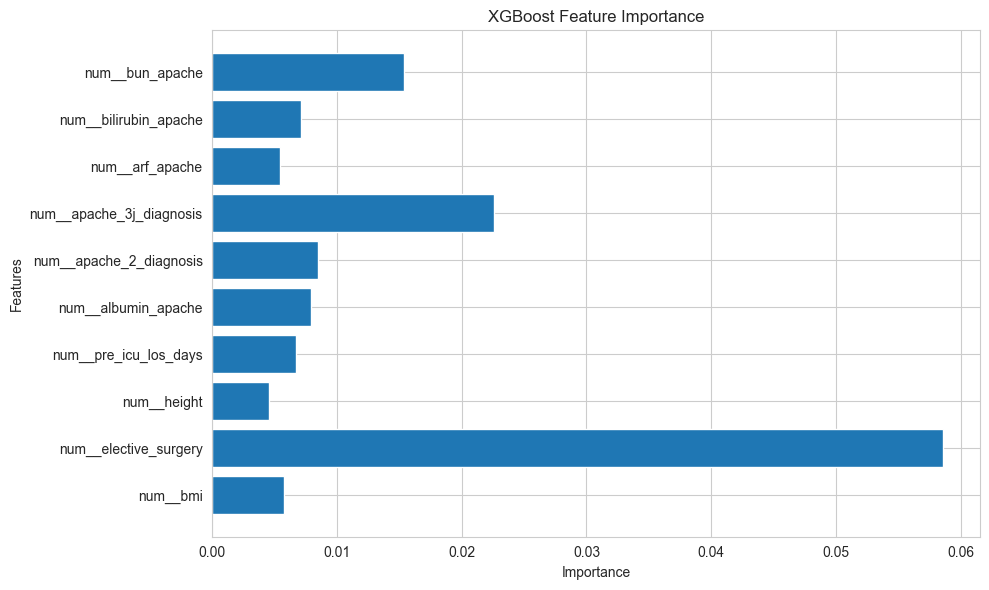

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(range(10), xg.feature_importances_[:10])
plt.yticks(range(10), X_train.columns[:10])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [19]:
xg_pred_test = xg.predict(X_test)
xg_pred_proba_test = xg.predict_proba(X_test)[:, 1]

In [20]:
xg_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
cm_xg = confusion_matrix(y_test, xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test, xg_pred_test)

Accuracy: 0.93
Precision: 0.68
Recall: 0.31
F1 Score: 0.43
TPR: 0.30973451327433627
TNR: 0.986159169550173


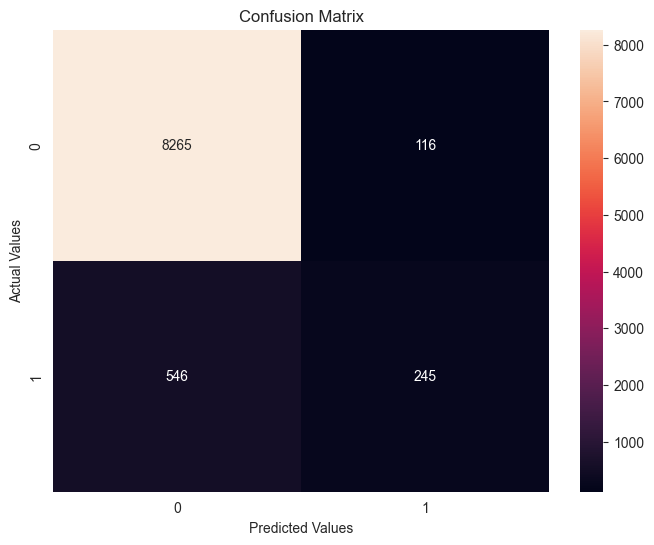

In [22]:
plotCFMatrix(cm_xg)

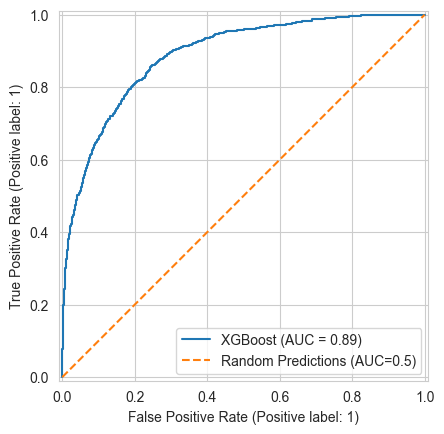

In [23]:
RocCurveDisplay.from_predictions(y_true=y_val, y_pred=xg_pred_proba, name='XGBoost')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

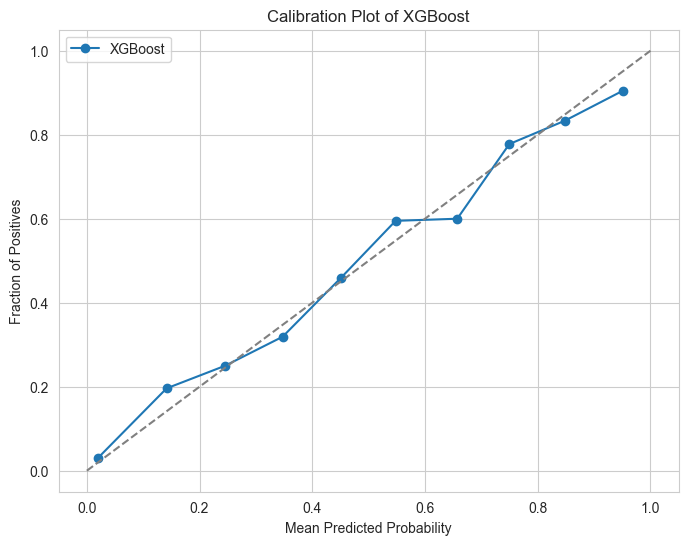

In [24]:
calibration_plot(y_val, xg_pred_proba, "XGBoost")

In [25]:
description[["Variable Name", "Description"]].loc[description["Variable Name"].str.contains("apache")]

,Variable Name,Description
19,albumin_apache,The albumin concentration measured during the ...
20,apache_2_diagnosis,The APACHE II diagnosis for the ICU admission
21,apache_3j_diagnosis,The APACHE III-J sub-diagnosis code which best...
22,apache_post_operative,The APACHE operative status; 1 for post-operat...
23,arf_apache,Whether the patient had acute renal failure du...
24,bilirubin_apache,The bilirubin concentration measured during th...
25,bun_apache,The blood urea nitrogen concentration measured...
26,creatinine_apache,The creatinine concentration measured during t...
27,fio2_apache,The fraction of inspired oxygen from the arter...
28,gcs_eyes_apache,The eye opening component of the Glasgow Coma ...


In [26]:
non_nan_apache = y_apache_test[~y_apache_test.isna()].index

In [27]:
y_apache_test_binary = (y_apache_test > 0.5).astype(int)

In [28]:
cm_xg = confusion_matrix(y_test[non_nan_apache], y_apache_test_binary[non_nan_apache])
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test[non_nan_apache], y_apache_test_binary[non_nan_apache])

Accuracy: 0.92
Precision: 0.58
Recall: 0.33
F1 Score: 0.42
TPR: 0.32737276478679506
TNR: 0.977436704709432


In [29]:
non_nan_apache_reset = y_apache_test.reset_index(drop=False)[y_apache_test.reset_index(drop=False)["index"].isin(non_nan_apache)].index

In [30]:
xg_pred_test = xg.predict(X_test.iloc[non_nan_apache_reset])
xg_pred_proba_test = xg.predict_proba(X_test.iloc[non_nan_apache_reset])[:, 1]

In [31]:
cm_xg = confusion_matrix(y_test[non_nan_apache], xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test[non_nan_apache], xg_pred_test)

Accuracy: 0.93
Precision: 0.68
Recall: 0.31
F1 Score: 0.43
TPR: 0.3108665749656121
TNR: 0.9860947133674406


In [32]:
X_test_with_index = X_test.copy().set_index(y_test.index)

In [33]:
df.ethnicity.value_counts()

ethnicity
Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: count, dtype: int64

In [34]:
X_test_caucasian = X_test_with_index.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Caucasian"].index]
y_test_caucasian = y_test.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Caucasian"].index]

X_test_african_american = X_test_with_index.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "African American"].index]
y_test_african_american = y_test.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "African American"].index]

X_test_other = X_test_with_index.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Other/Unknown"].index]
y_test_other = y_test.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Other/Unknown"].index]

X_test_hispanic = X_test_with_index.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Hispanic"].index]
y_test_hispanic = y_test.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Hispanic"].index]

X_test_asian = X_test_with_index.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Asian"].index]
y_test_asian = y_test.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Asian"].index]

X_test_native_american = X_test_with_index.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Native American"].index]
y_test_native_american = y_test.loc[df.iloc[y_test.index].loc[df.iloc[y_test.index].ethnicity == "Native American"].index]

In [35]:
xg_pred_test = xg.predict(X_test_caucasian)
xg_pred_proba_test = xg.predict_proba(X_test_caucasian)[:, 1]
cm_xg = confusion_matrix(y_test_caucasian, xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test_caucasian, xg_pred_test)

Accuracy: 0.93
Precision: 0.69
Recall: 0.31
F1 Score: 0.42
TPR: 0.3071786310517529
TNR: 0.9869747247635292


In [36]:
xg_pred_test = xg.predict(X_test_african_american)
xg_pred_proba_test = xg.predict_proba(X_test_african_american)[:, 1]
cm_xg = confusion_matrix(y_test_african_american, xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test_african_american, xg_pred_test)

Accuracy: 0.93
Precision: 0.57
Recall: 0.38
F1 Score: 0.45
TPR: 0.375
TNR: 0.974585635359116


In [37]:
xg_pred_test = xg.predict(X_test_other)
xg_pred_proba_test = xg.predict_proba(X_test_other)[:, 1]
cm_xg = confusion_matrix(y_test_other, xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test_other, xg_pred_test)

Accuracy: 0.93
Precision: 0.77
Recall: 0.26
F1 Score: 0.38
TPR: 0.2564102564102564
TNR: 0.9925558312655087


In [38]:
xg_pred_test = xg.predict(X_test_hispanic)
xg_pred_proba_test = xg.predict_proba(X_test_hispanic)[:, 1]
cm_xg = confusion_matrix(y_test_hispanic, xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test_hispanic, xg_pred_test)

Accuracy: 0.89
Precision: 0.75
Recall: 0.20
F1 Score: 0.32
TPR: 0.2
TNR: 0.9903846153846154


In [39]:
xg_pred_test = xg.predict(X_test_asian)
xg_pred_proba_test = xg.predict_proba(X_test_asian)[:, 1]
cm_xg = confusion_matrix(y_test_asian, xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test_asian, xg_pred_test)

Accuracy: 0.94
Precision: 0.71
Recall: 0.50
F1 Score: 0.59
TPR: 0.5
TNR: 0.9803921568627451


In [40]:
xg_pred_test = xg.predict(X_test_native_american)
xg_pred_proba_test = xg.predict_proba(X_test_native_american)[:, 1]
cm_xg = confusion_matrix(y_test_native_american, xg_pred_test)
accuracy_xg, precision_xg, recall_xg, f1_xg, tpr_xg, tnr_xg = Metrics(y_test_native_american, xg_pred_test)

Accuracy: 0.95
Precision: 1.00
Recall: 0.56
F1 Score: 0.71
TPR: 0.5555555555555556
TNR: 1.0


In [41]:
import shap

In [43]:
explainer = shap.Explainer(xg)
shap_values = explainer(X_test)

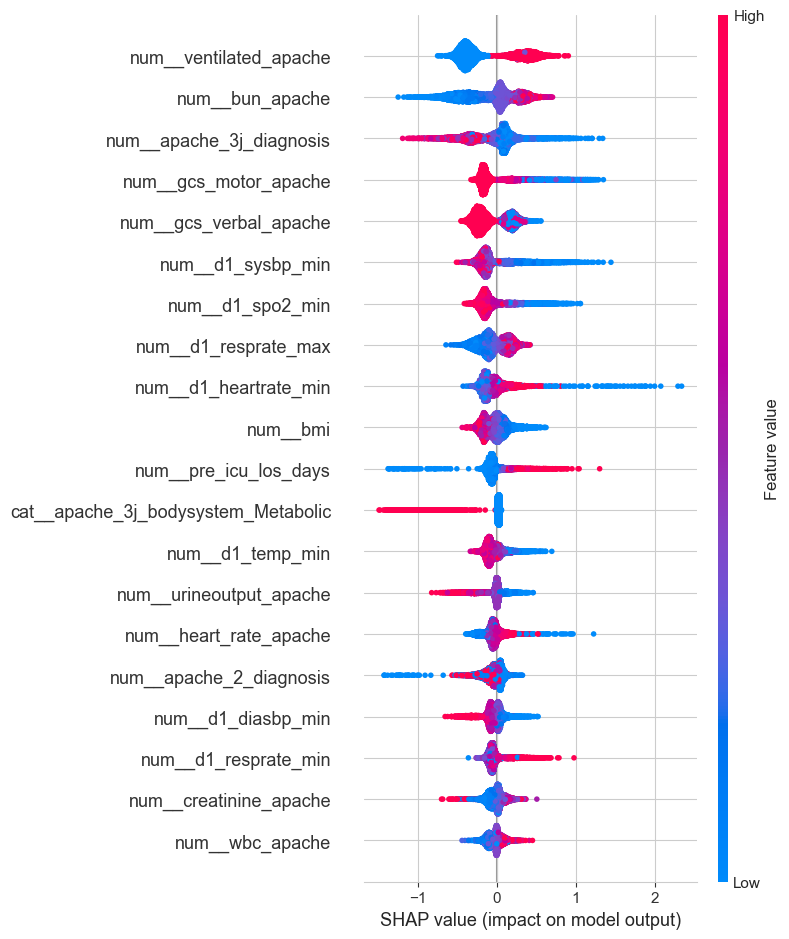

In [50]:
shap.summary_plot(shap_values, X_test)

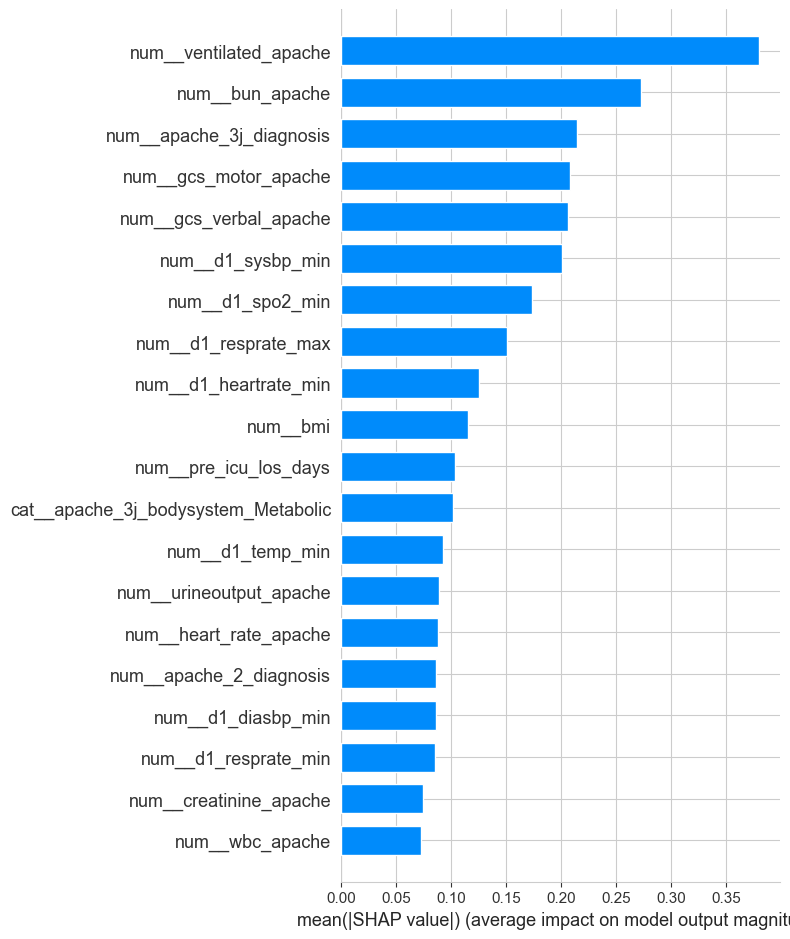

In [51]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The num_ventilated_apache is a binary feature, the values at ~0.3 are because there are values with NaN with get imputed

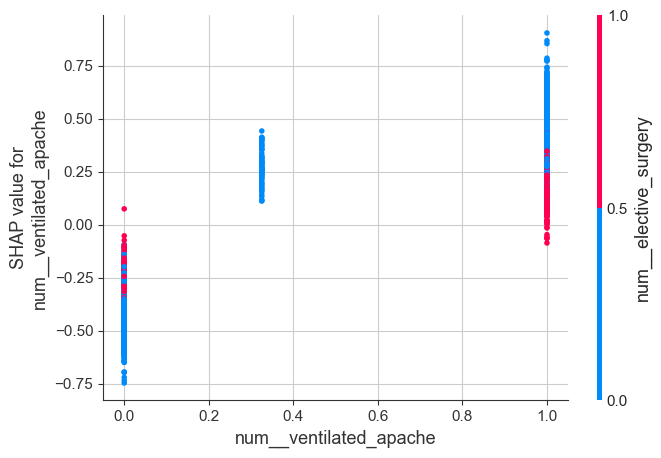

In [ ]:
shap.dependence_plot("num__ventilted_apache", shap_values.values, X_test)

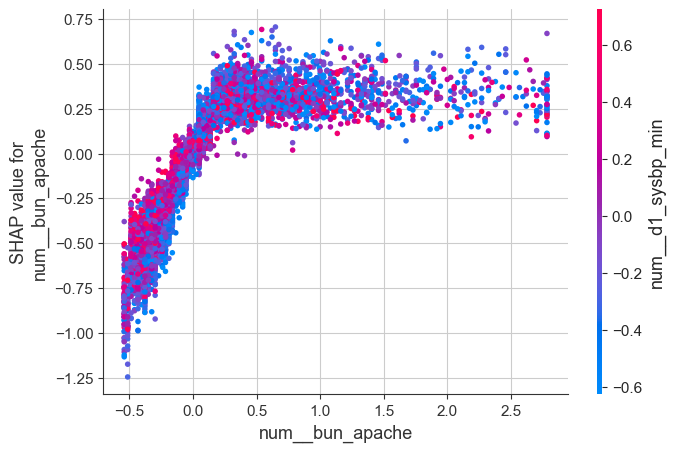

In [77]:
shap.dependence_plot("num__bun_apache", shap_values.values, X_test)

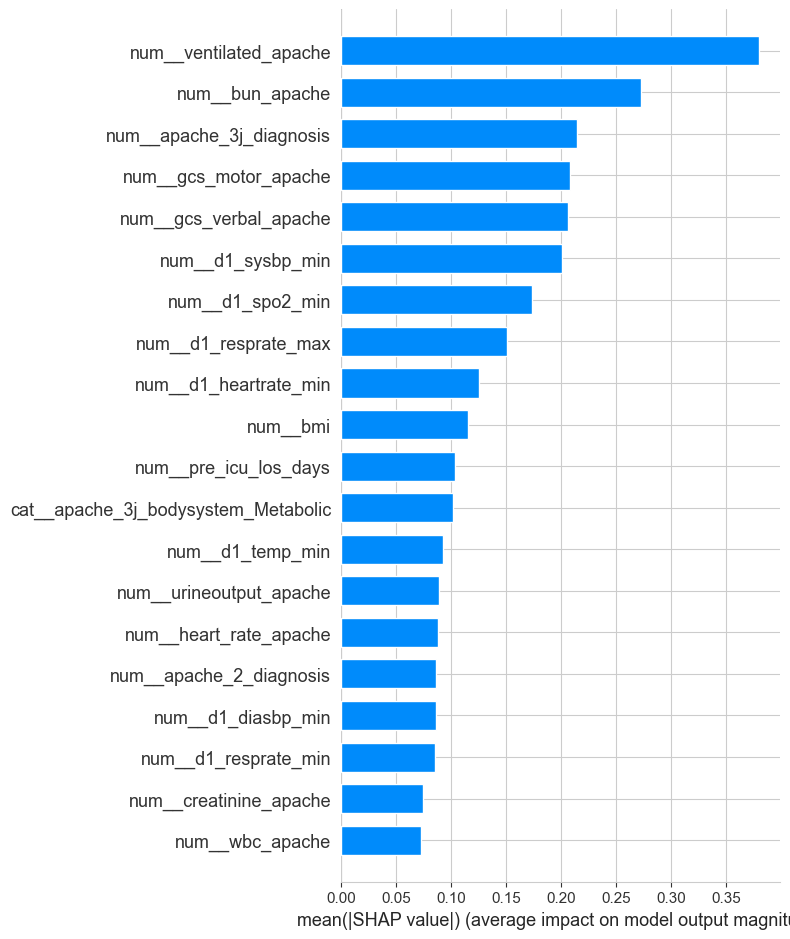

In [56]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

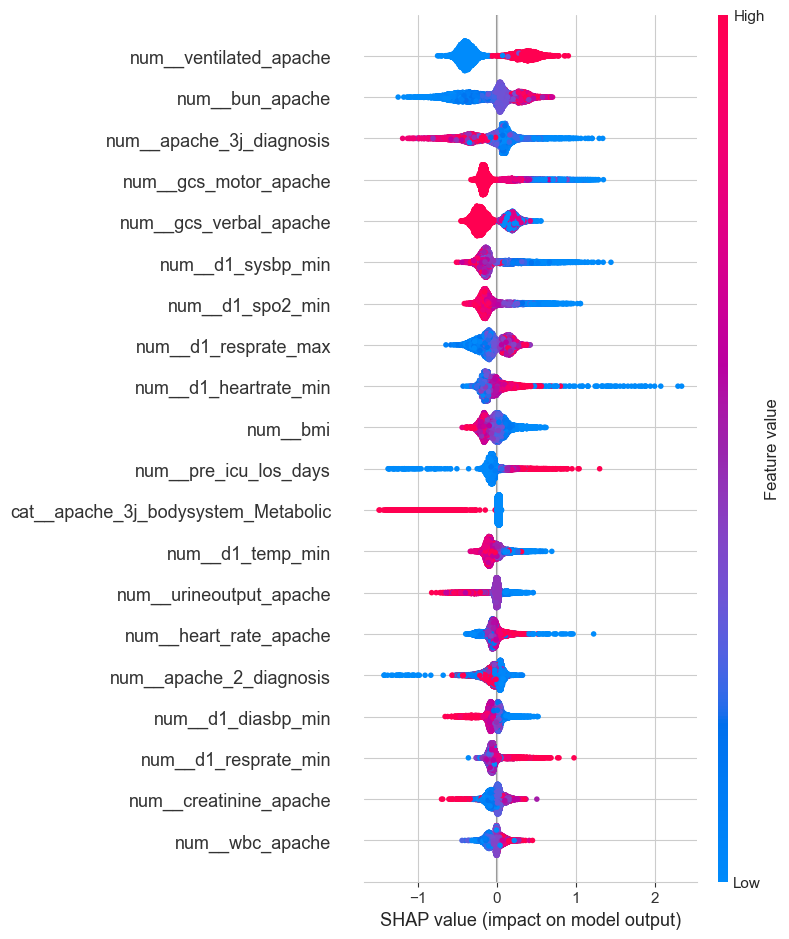

In [58]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

In [61]:
most_important_feature

'num__ventilated_apache'

<Figure size 1000x700 with 0 Axes>

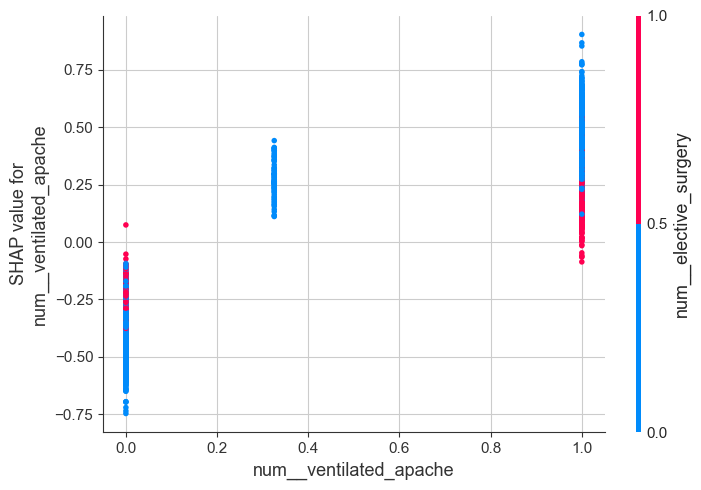

In [60]:
most_important_feature = X_test.columns[np.argmax(np.abs(shap_values.values).mean(0))]
plt.figure(figsize=(10, 7))
shap.dependence_plot(most_important_feature, shap_values.values, X_test, show=False)
plt.tight_layout()
plt.show()

In [64]:
description_dict["ventilated_apache"]

{'Category': 'APACHE covariate',
 'Unit of Measure': nan,
 'Data Type': 'binary',
 'Description': 'Whether the patient was invasively ventilated at the time of the highest scoring arterial blood gas using the oxygenation scoring algorithm, including any mode of positive pressure ventilation delivered through a circuit attached to an endo-tracheal tube or tracheostomy',
 'Example': '1'}

In [73]:
data_types = set()
for key in description_dict.keys():
    data_types.add(description_dict[key]["Data Type"])
    if "binary" in description_dict[key]["Data Type"]:
        print(key, description_dict[key])

hospital_death {'Category': 'demographic', 'Unit of Measure': nan, 'Data Type': 'binary', 'Description': 'Whether the patient died during this hospitalization', 'Example': '0'}
elective_surgery {'Category': 'demographic', 'Unit of Measure': nan, 'Data Type': 'binary', 'Description': 'Whether the patient was admitted to the hospital for an elective surgical operation', 'Example': '0'}
readmission_status {'Category': 'demographic', 'Unit of Measure': nan, 'Data Type': 'binary', 'Description': 'Whether the current unit stay is the second (or greater) stay at an ICU within the same hospitalization', 'Example': '0'}
apache_post_operative {'Category': 'APACHE covariate', 'Unit of Measure': nan, 'Data Type': 'binary', 'Description': 'The APACHE operative status; 1 for post-operative, 0 for non-operative', 'Example': '1'}
arf_apache {'Category': 'APACHE covariate', 'Unit of Measure': nan, 'Data Type': 'binary', 'Description': 'Whether the patient had acute renal failure during the first 24 hou

In [74]:
data_types

{'binary', 'integer', 'numeric', 'string'}

In [68]:
X_train["num__ventilated_apache"]

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
73365    1.000000
73366    0.000000
73367    0.000000
73368    1.000000
73369    0.325395
Name: num__ventilated_apache, Length: 73370, dtype: float64

In [ ]:
X_test.columns

Index(['num__bmi', 'num__elective_surgery', 'num__height',
       'num__pre_icu_los_days', 'num__albumin_apache',
       'num__apache_2_diagnosis', 'num__apache_3j_diagnosis',
       'num__arf_apache', 'num__bilirubin_apache', 'num__bun_apache',
       ...
       'cat__apache_3j_bodysystem_Genitourinary',
       'cat__apache_3j_bodysystem_Gynecological',
       'cat__apache_3j_bodysystem_Hematological',
       'cat__apache_3j_bodysystem_MISSING',
       'cat__apache_3j_bodysystem_Metabolic',
       'cat__apache_3j_bodysystem_Musculoskeletal/Skin',
       'cat__apache_3j_bodysystem_Neurological',
       'cat__apache_3j_bodysystem_Respiratory',
       'cat__apache_3j_bodysystem_Sepsis', 'cat__apache_3j_bodysystem_Trauma'],
      dtype='object', length=108)

ValueError: too many values to unpack (expected 1)

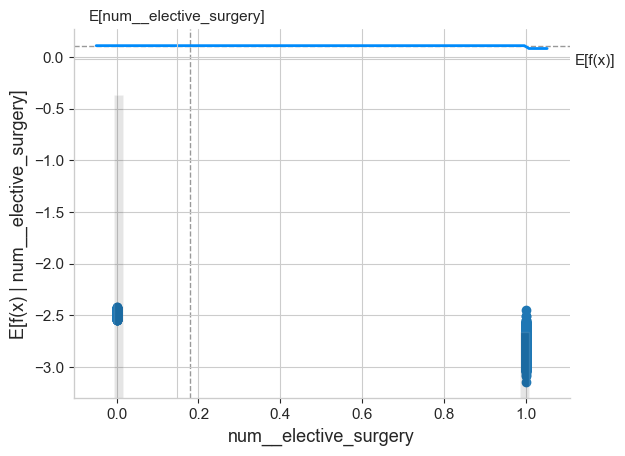

In [203]:
shap.plots.partial_dependence(
    ind=1,
    model=xg.predict,
    data=X_test,
    ice=False,
    model_expected_value=True,  # Show the model's expected value
    feature_expected_value=True,  # Show the feature's expected value
    shap_values=shap_values,  # SHAP values
)

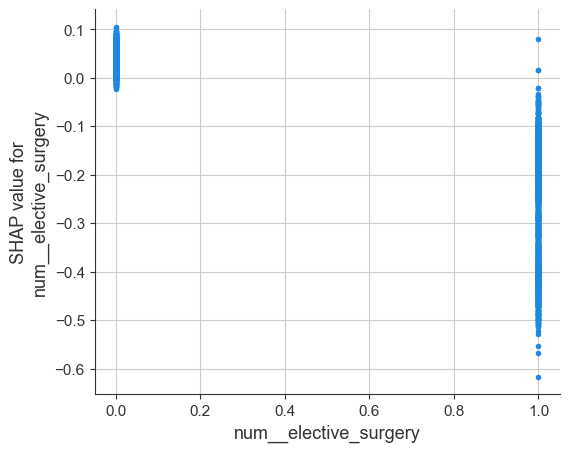

In [207]:
shap.dependence_plot("num__elective_surgery", shap_values.values, X_test, interaction_index=None)

In [183]:
df[["elective_surgery", "hospital_death"]].groupby("elective_surgery").value_counts()

elective_surgery  hospital_death
0                 0                 67468
                  1                  7394
1                 0                 16330
                  1                   521
Name: count, dtype: int64

In [184]:
7394 / 67468

0.10959269579652577

In [185]:
521 / 16330

0.03190447030006124